## <center> **Задача 2. Володин**

### Чем активнее наши пользователи – тем выше нагрузка на сервера. И в последнее время нам всё чаще приходят жалобы, что приложение подвисает. От нас требуется спрогнозировать как изменится активность пользователей в течение ближайшего месяца.

In [2]:
import orbit #общий пакет
from orbit.models import DLT #один из вариантов модели
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components #для рисования прогноза
from orbit.diagnostics.backtest import BackTester #основной класс для бэктестинга
from orbit.utils.params_tuning import grid_search_orbit #для подбора оптимальных параметров
import arviz as az

import pandas as pd
import pandahouse
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

## **1. Метрика**

Информации, к сожалению, у нас не очень много. Что вообще считать активностью и нагрузкой? От чего именно зависит нагрузка? Насколько лайки или сообщения увеличивают нагрузку, отличается ли нагрузка от лайка от нагрузки, например, из-за просмотра или создания нового поста? А от времени онлайн? Ах, слава богу у нас такого нет. Исходя из предоставленных данных, у меня есть три версии как поступить:

**1.** Считать основной метрикой DAU или другой эквивалент, поскольку чем больше пользователей, тем больше нагрузка на сервер. Вроде бы звучит логично, но ведь наверняка нагрузка зависит от количества действий, которые пользователь совершает. Пользователь X просмотрел 1 пост и вышел, он как бы пополнил метрику DAU, но вряд ли создал большую нагрузку, чем пользователь Y, который посмотрел все посты по два раза и каждый лайкнул.

**2.** Считать количество действий, т.е. количество лайков и просмотров. Для удобства и простоты мессенджер рассматривать не будем. А активных пользователей использовать, например, как регрессор.

**3.** У меня не хватает времени на выполнение этого дз с излишним энтузиазмом, но закинуть мысль стоит. А что, если для каждого действий придумать свой "коэффициент нагрузки". Раз нам не дают информацию об этой нагрузке, то давайте насинтезируем данные. Примерно так:
- появление нового пользователя - 10 баллов;
- пост - 5 баллов;
- сообщение - 3 балла;
- лайк - 2 балла;
- просмотр - 1 балл.

Но, к сожалению, у такого подхода есть один маааленький недостаток, у нас могут получиться абсолютно оторванные от реальности игрушечные данные, анализ которых не несет никакой практической ценности :(

Поэтому остановимся на 2 варианте. Данные будем анализировать с часовым интервалом, ведь сто процентов активность в 5 утра и в 6 вечера сильно отличаются.

In [3]:
# параметры подключения
# наверное, их стоило удалить?..
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230720'
}

In [4]:
# для оптимизации заранее посчитаем стр для каждого пользователя
q = """
    SELECT
        hour_time,
        actions, 
        IF(date BETWEEN '2023-07-13' AND '2023-07-21', 1, 0) AS event,
        toDayOfWeek(date) AS day_of_week,
        multiIf(hour <= 5, 0, hour <=11, 1, hour <=17, 2, 3) AS time_of_day, 
        active_users
    FROM (
        SELECT
            toStartOfHour(time) AS hour_time,
            toDate(time) AS date,
            toHour(time) AS hour,
            COUNT(post_id) AS actions,
            COUNT(DISTINCT user_id) AS active_users
        FROM simulator_20230720.feed_actions
        GROUP BY hour_time, date, hour
        ORDER BY hour_time
     ) AS a
     WHERE date < toDate(today())
     ORDER BY hour_time
"""

# продолжим работу с пандасом, проверим данные
df = pandahouse.read_clickhouse(q, connection=connection)
df.head()

,hour_time,actions,event,day_of_week,time_of_day,active_users
0,2023-06-03 00:00:00,22,0,6,0,14
1,2023-06-03 01:00:00,32,0,6,0,26
2,2023-06-03 02:00:00,24,0,6,0,16
3,2023-06-03 03:00:00,11,0,6,0,11
4,2023-06-03 04:00:00,18,0,6,0,14


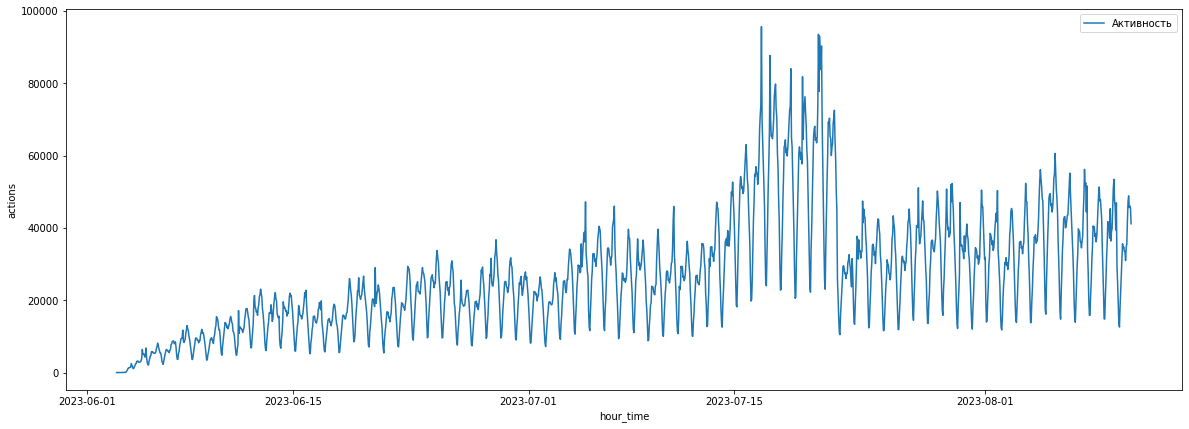

In [5]:
# строим график
fig = plt.figure(figsize=(20,7))
sns.lineplot(df, x='hour_time', y='actions', label='Активность');

**Вывод по графику:**   
Так, ну чет ниче не понятно. Но то есть да, есть тренд, какой-то скачок активности (см. задание 1), есть какая-то сезонность. Давайте немного сократим данные для наглядности.
________

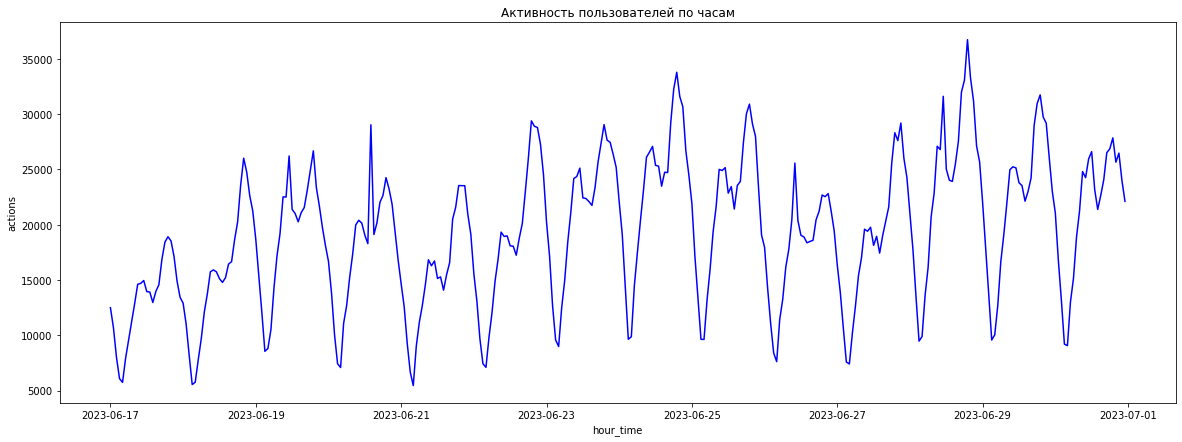

In [31]:
short_df = df[336:672]

# строим график
fig = plt.figure(figsize=(20,7))
sns.lineplot(short_df, x='hour_time', y='actions', color='blue').set(title='Активность пользователей по часам');

**Вывод к графику:**  
При интерактивном изучении графика картина сильно понятнее, но в целом и по этому графику угадывается, что минимум около 4 утра, а наибольший пик активности в вечерние часы. То есть активность имеет суточную сезонность.
_____

## **2.** Добавим регрессоры

Попробуем взять количество активных пользователей по часам (далее, AUpH) в качестве основного регрессора. Очень вероятно, что количество активных пользователей и количество действий будут иметь высокую корреляцию.

In [32]:
# # для начала впринипе проверим корреляцию
corr = df.corr()
corr_df = pd.DataFrame(round(corr[['actions', 'active_users']].apply(lambda x: abs(x)).sort_values(ascending=False, by='actions'), 3))
corr_df

,actions,active_users
actions,1.000,0.822
active_users,0.822,1.000
hour_time,0.647,0.702
event,0.568,0.169
time_of_day,0.403,0.496
day_of_week,0.037,0.069


Да, действительно количество активных пользователей очень сильно влияет на активность, да и параметр времени  дня и ивента имеют высокую корреляцию. Мультиколлинеарных признаков нет.
В таком случае, учитывая коэффициенты корреляции, давайте попробуем для предсказания регрессора AUpH использовать день недели и время дня, раз у них более высокая корреляция. А для предсказания основной метрики активности (количество действий) будем использовать признак ивента и AUpH.

### **2.1.** Проба пера

In [6]:
# построим модель
auph_model = DLT(
    response_col='active_users',
    date_col='hour_time',
    seasonality=24,
    estimator='stan-map',
    n_bootstrap_draws=1000,
    regressor_col=['day_of_week', 'time_of_day'],
    regression_penalty='auto_ridge'
)

# обучаем модель и создаем датасет для предсказаний
auph_model.fit(df)
future_df = auph_model.make_future_df(periods=24*31)

2023-08-11 15:23:47 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.


In [7]:
def get_time_of_day(hour):
    """функция для подсчета времени дня"""
    
    if hour <= 5:
        return 0   
    
    if hour <= 11:
        return 1
    
    if hour <= 17:
        return 2
    
    else:
        return 3

In [8]:
# добавим нужные признаки
future_df['day_of_week'] = future_df['hour_time'].dt.dayofweek
future_df['time_of_day'] = future_df['hour_time'].dt.hour.apply(get_time_of_day)
future_df.head()

,hour_time,day_of_week,time_of_day
0,2023-08-11 00:00:00,4,0
1,2023-08-11 01:00:00,4,0
2,2023-08-11 02:00:00,4,0
3,2023-08-11 03:00:00,4,0
4,2023-08-11 04:00:00,4,0


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

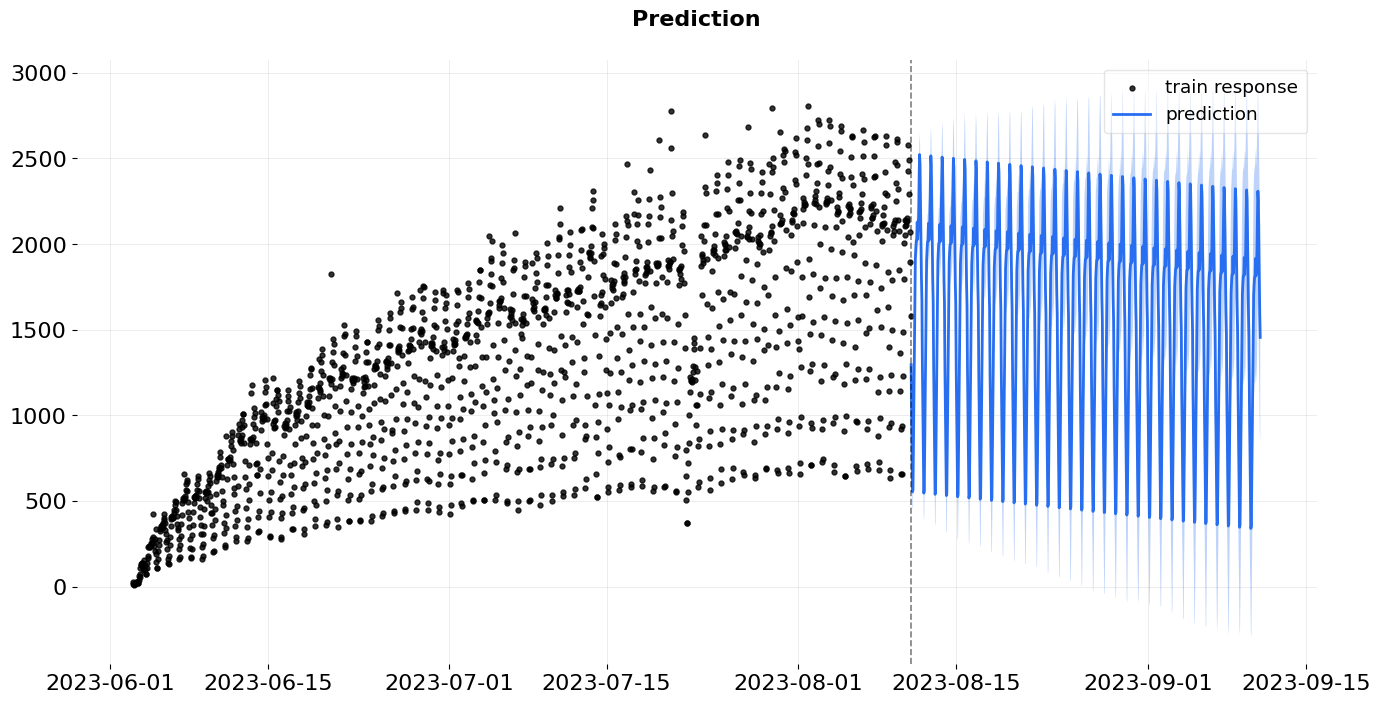

In [9]:
# предсказываем значения
predicted_auph = auph_model.predict(future_df)

_ = plot_predicted_data(df, #изначальные данные
                        predicted_auph, #датафрейм с предсказаниями
                        'hour_time', #колонка со временем
                        'active_users', #колонка со значениями временного ряда
                        title='Prediction') #заголовок рисунка

**Вывод к графику:**  
Ну, в целом, я ожидал чего похуже. В целом можно сказать, что модель хотя бы адекватно работает. Попробуем ее улучшить.
____

### **2.2.** Бэктестинг

Попробуем вариант с разными типами окон.

In [11]:
# настраиваем тестер с расширяющимся окном
bt = BackTester(
    model=auph_model,
    df=df,
    min_train_len=24*14,
    incremental_len=24*2,
    forecast_len=24*2,
    window_type='expanding',
)

# и обучаем его
bt.fit_predict()

In [12]:
print('Расширяющееся окно: \n', bt.score())

Расширяющееся окно: 
   metric_name  metric_values  is_training_metric
0       smape       0.111571               False
1       wmape       0.094642               False
2        mape       0.106627               False
3         mse   53361.085658               False
4         mae     137.273075               False
5       rmsse       1.245880               False


In [13]:
# настраиваем тестер со скользящим окном
bt = BackTester(
    model=auph_model,
    df=df,
    min_train_len=24*14,
    incremental_len=24*2,
    forecast_len=24*2,
    window_type='rolling',
)

# и обучаем его
bt.fit_predict()

In [14]:
print('Скользящее окно: \n', bt.score())

Скользящее окно: 
   metric_name  metric_values  is_training_metric
0       smape       0.175304               False
1       wmape       0.170098               False
2        mape       0.185612               False
3         mse  157020.321740               False
4         mae     246.718910               False
5       rmsse       2.137184               False


Вариант с расширяющимся окном показывает меньшие значения метрики.

### **2.3.** Оптимизация гиперпараметров

In [36]:
# настраиваем сетку параметров
param_grid = {'damped_factor': [0.3, 0.5, 0.8],
             'seasonality_sm_input': [0.3, 0.5, 0.8]}

In [13]:
# подберем лучшие параметры
best_params, tuned_df = grid_search_orbit(
    param_grid = param_grid,
    model=auph_model,
    df=df,
    min_train_len=24*14,
    incremental_len=24*2,
    forecast_len=24*2,
    metrics=None,
    criteria='min',
    verbose=True
)

  0%|          | 0/27 [00:00<?, ?it/s]

2023-08-11 13:31:22 - orbit - INFO - tuning hyper-params {'damped_factor': 0.1, 'seasonality_sm_input': 0.3}
2023-08-11 13:31:22 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
2023-08-11 13:31:45 - orbit - INFO - tuning metric:0.10268
2023-08-11 13:31:45 - orbit - INFO - tuning hyper-params {'damped_factor': 0.1, 'seasonality_sm_input': 0.5}
2023-08-11 13:31:45 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
2023-08-11 13:32:18 - orbit - INFO - tuning metric:0.11079
2023-08-11 13:32:18 - orbit - INFO - tuning hyper-params {'damped_factor': 0.1, 'seasonality_sm_input': 0.8}
2023-08-11 13:32:18 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
2023-08-11 13:32:46 - orbit - INFO - tuning metric:0.098442
2023-08-11 13:32:46 - orbit - INFO - tuning hyper-params {'damped_factor': 0.2, 'seasonality_sm_input': 0.3}
2023-08-11 13:32:46 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
2023-08-11 13:33:09 - orbit - INFO - tuning metric:0.10126
2023-08

In [14]:
best_params

[{'damped_factor': 0.4, 'seasonality_sm_input': 0.5}]

### **2.4.** Добавляем ключевой регрессор для предсказаний

In [10]:
# построим модель
auph_model = DLT(
    response_col='active_users',
    date_col='hour_time',
    seasonality=24,
    estimator='stan-map',
    n_bootstrap_draws=5000,
    regressor_col=['day_of_week', 'time_of_day'],
    regression_penalty='auto_ridge',
    damped_factor=0.4,
    seasonality_sm_input=0.5
)

# обучаем модель и создаем датасет для предсказаний
auph_model.fit(df)

2023-08-11 15:24:05 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

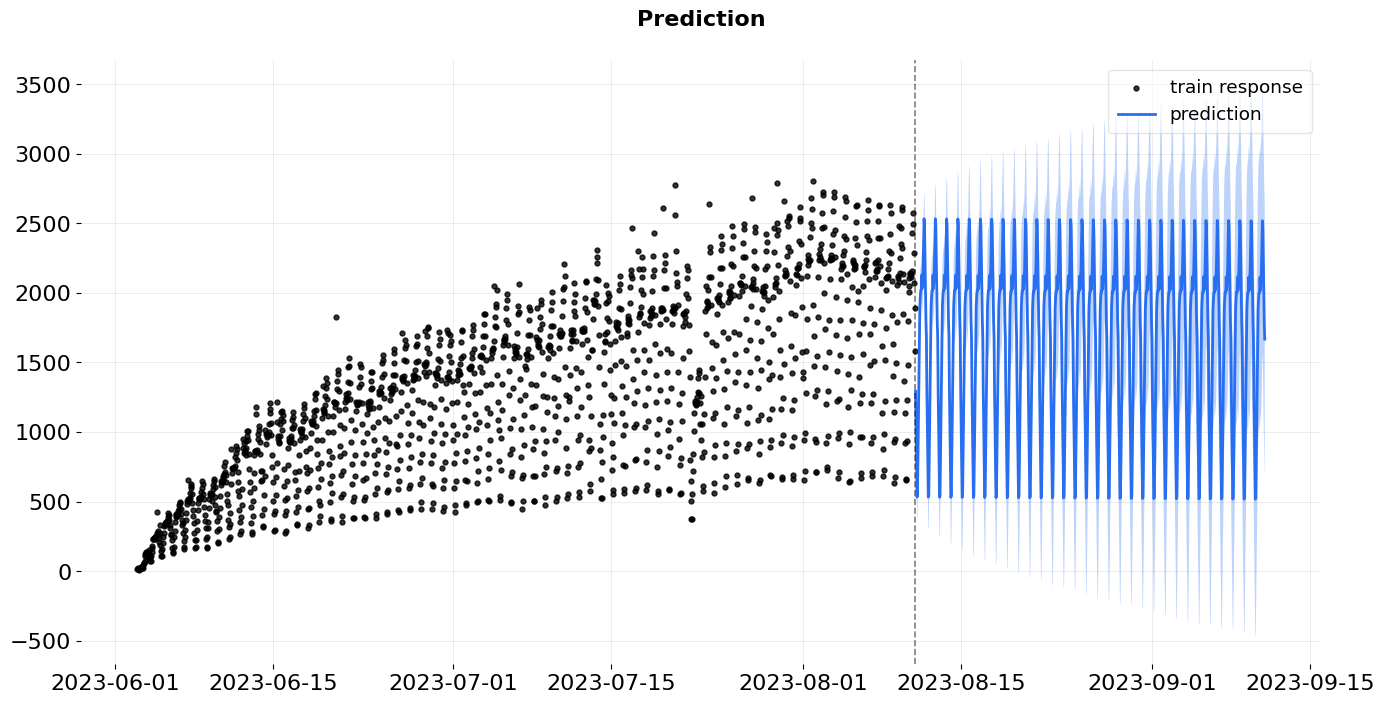

In [11]:
# предсказываем значения
predicted_auph = auph_model.predict(future_df)

_ = plot_predicted_data(df, #изначальные данные
                        predicted_auph, #датафрейм с предсказаниями
                        'hour_time', #колонка со временем
                        'active_users', #колонка со значениями временного ряда
                        title='Prediction') #заголовок рисунка

**Вывод к графику:**  
Объективно, модель не уловила глобальный тренд роста количества активных юзеров. Доверительный интервал уже через 2 недели дает совсем уж аномальные результаты, особенно это касается отрицательных результатов.  
С учетом того, что у нас появляются жалобы на замедление работы приложения, что не допустимо, а прогноз необходимо сделать на месяц вперед, то предлагаю взять наиболее оптимистичный сценарий количества активных пользователей. Для этого возьмем среднее от предсказанного значения и верхнего доверительного интервала.
________

## **3.** Выбор модели

### **3.1.** Модель stan-map

In [12]:
new_df = df[['hour_time', 'event', 'active_users', 'actions']]
new_df[['event', 'active_users', 'actions']] = new_df[['event', 'active_users', 'actions']].astype(float)
new_df.head()

/tmp/ipykernel_6606/2145598871.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[['event', 'active_users', 'actions']] = new_df[['event', 'active_users', 'actions']].astype(float)


,hour_time,event,active_users,actions
0,2023-06-03 00:00:00,0.0,14.0,22.0
1,2023-06-03 01:00:00,0.0,26.0,32.0
2,2023-06-03 02:00:00,0.0,16.0,24.0
3,2023-06-03 03:00:00,0.0,11.0,11.0
4,2023-06-03 04:00:00,0.0,14.0,18.0


In [13]:
# построим модель
stan_map = DLT(
    response_col='actions',
    date_col='hour_time',
    seasonality=24,
    estimator='stan-map',
    n_bootstrap_draws=1000,
    regressor_col=['active_users', 'event']
)

# обучаем модель и создаем датасет для предсказаний
stan_map.fit(df)
future_df = stan_map.make_future_df(periods=24*31)

2023-08-11 15:24:19 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.


In [14]:
# дополним датасет регрессорами
future_df['active_users'] = (predicted_auph['prediction'] + predicted_auph['prediction_95']) / 2
future_df['event'] = 0

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

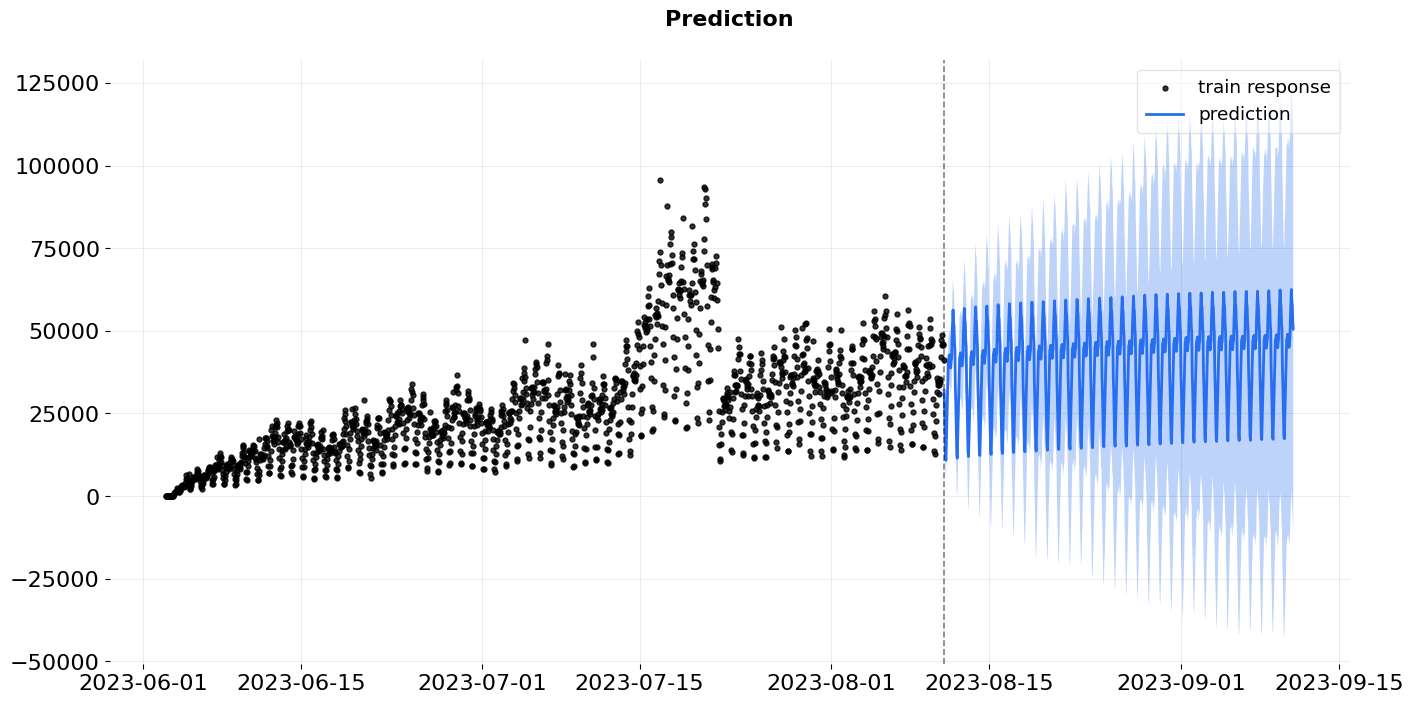

In [15]:
# предсказываем значения
predicted_stan_map = stan_map.predict(future_df)

_ = plot_predicted_data(new_df, #изначальные данные
                        predicted_stan_map, #датафрейм с предсказаниями
                        'hour_time', #колонка со временем
                        'actions', #колонка со значениями временного ряда
                        title='Prediction') #заголовок рисунка

**Вывод по графику:**  
В целом очень даже ничего получилось, есть объективный оптимистичный рост активности. Но доверительные интервалы уж слишком широкие.
______

Далее проведем настройку гиперпараметров.

In [21]:
# настраиваем сетку параметров
param_grid = {'damped_factor': [0.1, 0.5, 0.9],
             'seasonality_sm_input': [0.1, 0.5, 0.9]}

In [22]:
# подберем лучшие параметры
best_params, tuned_df = grid_search_orbit(
    param_grid = param_grid,
    model=stan_map,
    df=new_df,
    min_train_len=24*14,
    incremental_len=24*2,
    forecast_len=24*2,
    criteria='min',
    verbose=True
)

  0%|          | 0/9 [00:00<?, ?it/s]

2023-08-11 13:44:51 - orbit - INFO - tuning hyper-params {'damped_factor': 0.1, 'seasonality_sm_input': 0.1}
2023-08-11 13:44:51 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
2023-08-11 13:45:11 - orbit - INFO - tuning metric:0.19324
2023-08-11 13:45:11 - orbit - INFO - tuning hyper-params {'damped_factor': 0.1, 'seasonality_sm_input': 0.5}
2023-08-11 13:45:11 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
2023-08-11 13:45:31 - orbit - INFO - tuning metric:0.16289
2023-08-11 13:45:31 - orbit - INFO - tuning hyper-params {'damped_factor': 0.1, 'seasonality_sm_input': 0.9}
2023-08-11 13:45:31 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
2023-08-11 13:45:51 - orbit - INFO - tuning metric:0.14869
2023-08-11 13:45:51 - orbit - INFO - tuning hyper-params {'damped_factor': 0.5, 'seasonality_sm_input': 0.1}
2023-08-11 13:45:51 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
2023-08-11 13:46:12 - orbit - INFO - tuning metric:0.19971
2023-08-

In [23]:
print('Оптимальные параметры:', best_params)

Оптимальные параметры: [{'damped_factor': 0.5, 'seasonality_sm_input': 0.9}]


Теперь на очереди оценка результатов модели.

In [16]:
# добавляем настроенные гиперпараметры
stan_map = DLT(
    response_col='actions',
    date_col='hour_time',
    seasonality=24,
    estimator='stan-map',
    n_bootstrap_draws=1000,
    regressor_col=['active_users', 'event'],
    regression_penalty='auto_ridge',
    damped_factor=0.5,
    seasonality_sm_input=0.9
)

# обучаем модель и создаем датасет для предсказаний
stan_map.fit(df)

2023-08-11 15:24:30 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.


In [44]:
# настраиваем тестер с расширяющимся окном
stan_map_bt = BackTester(
    model=stan_map,
    df=new_df,
    min_train_len=24*14,
    incremental_len=24*2,
    forecast_len=24*2,
    window_type='expanding'
)

# и обучаем его
stan_map_bt.fit_predict()

In [45]:
print('Метрики: \n', stan_map_bt.score())

Метрики: 
   metric_name  metric_values  is_training_metric
0       smape   1.653726e-01               False
1       wmape   1.590505e-01               False
2        mape   1.795252e-01               False
3         mse   5.815181e+07               False
4         mae   4.861234e+03               False
5       rmsse   1.685122e+00               False


### **3.2.** Модель stan-mcmc

In [46]:
# построим модель
stan_mcmc = DLT(
    response_col='actions',
    date_col='hour_time',
    seasonality=24,
    estimator='stan-mcmc',
    num_warmup=2000,
    num_sample=1000,
    regressor_col=['active_users', 'event'],
    damped_factor=0.5,
    seasonality_sm_input=0.9
)

# обучаем модель и создаем датасет для предсказаний
stan_mcmc.fit(df)

2023-08-11 14:50:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

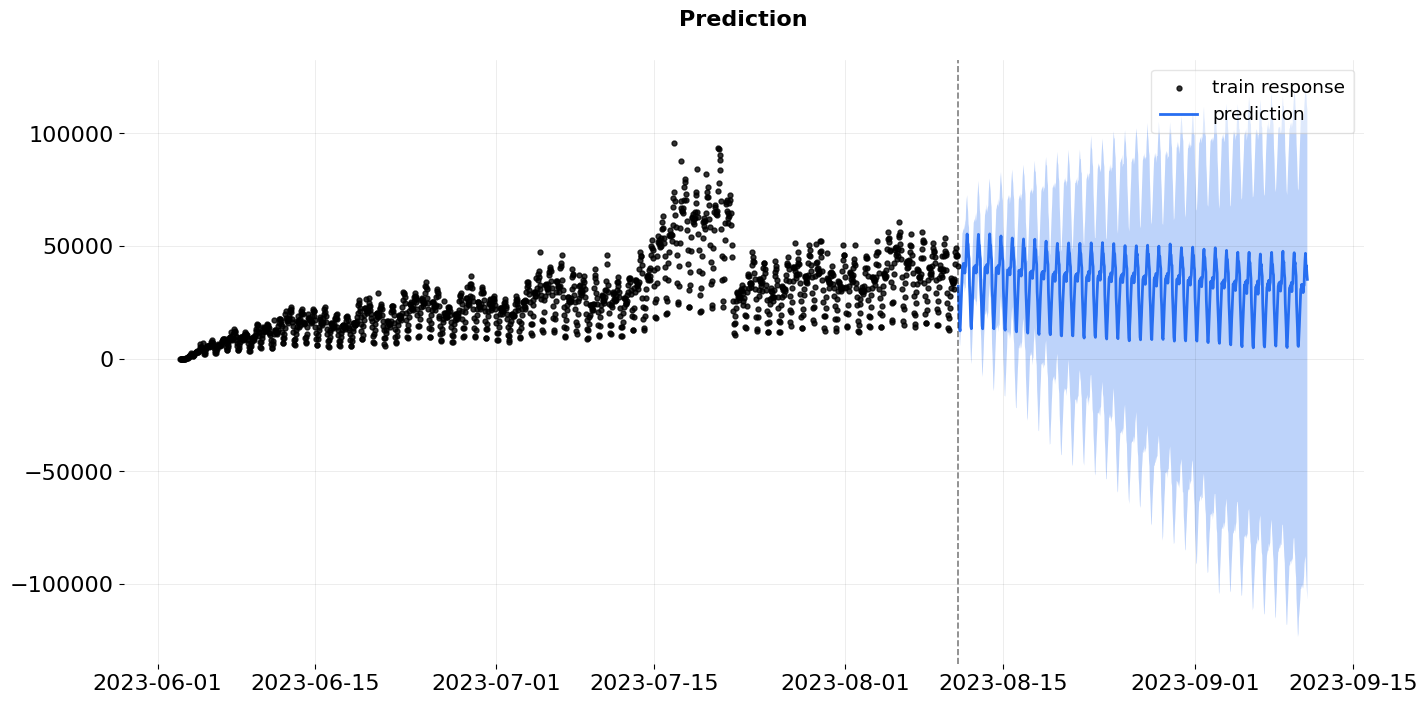

In [47]:
# предсказываем значения
predicted_stan_mcmc = stan_mcmc.predict(future_df)

_ = plot_predicted_data(new_df, #изначальные данные
                        predicted_stan_mcmc, #датафрейм с предсказаниями
                        'hour_time', #колонка со временем
                        'actions', #колонка со значениями временного ряда
                        title='Prediction') #заголовок рисунка

**Вывод по графику:**  
Визуально результаты отличаются от построенной ранее модели с алгоритмом stan-map, наш тренд роста активности сменился на незначительное убывание активности. Попробуем чего-нибудь улучшить.
______

In [48]:
# настраиваем тестер с расширяющимся окном
stan_mcmc_bt = BackTester(
    model=stan_mcmc,
    df=new_df,
    min_train_len=24*14,
    incremental_len=24*2,
    forecast_len=24*14,
    window_type='rolling',
)

# и обучаем его
stan_mcmc_bt.fit_predict()

2023-08-11 14:52:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-08-11 14:53:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-08-11 14:53:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-08-11 14:53:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-08-11 14:53:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-08-11 14:54:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-08-11 14:54:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-08-11 14:55:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-08-11 14:55:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-08-11 14:56:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-08-11 14:56:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-08-11 14:56:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-08-11 14:56:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-08-11 14:57:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-08-11 14:57:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-08-11 14:57:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-08-11 14:58:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-08-11 14:58:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-08-11 14:58:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-08-11 14:59:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-08-11 14:59:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [49]:
print('Метрики: \n', stan_mcmc_bt.score())

Метрики: 
   metric_name  metric_values  is_training_metric
0       smape   4.523660e-01               False
1       wmape   4.972078e-01               False
2        mape   5.085047e-01               False
3         mse   5.755657e+08               False
4         mae   1.572643e+04               False
5       rmsse   4.985979e+00               False


Проверим нашу модель с алгоритмом MCMC на сходимость параметров.

array([[<Axes: title={'center': 'obs_sigma'}>,
        <Axes: title={'center': 'obs_sigma'}>]], dtype=object)

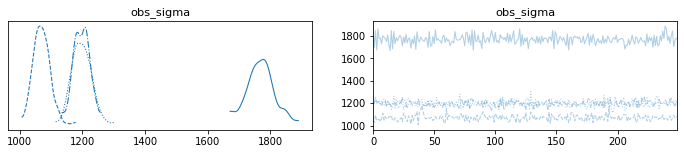

In [50]:
params = stan_mcmc.get_posterior_samples(permute=False, relabel=True) #достаём информацию о параметрах

az.plot_trace(params, var_names='obs_sigma')

Мы видим, что однозначно наша модель не сошлась, одна цепь сильно отличается, а другая вообще мимо. Попробуем увеличить количество итераций.

In [17]:
# построим модель
stan_mcmc = DLT(
    response_col='actions',
    date_col='hour_time',
    seasonality=24,
    estimator='stan-mcmc',
    num_warmup=5000,
    num_sample=5000,
    regressor_col=['active_users', 'event'],
    damped_factor=0.4,
    seasonality_sm_input=0.5
)

# обучаем модель и создаем датасет для предсказаний
stan_mcmc.fit(df)

2023-08-11 15:25:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 1250 and samples(per chain): 1250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

array([[<Axes: title={'center': 'obs_sigma'}>,
        <Axes: title={'center': 'obs_sigma'}>]], dtype=object)

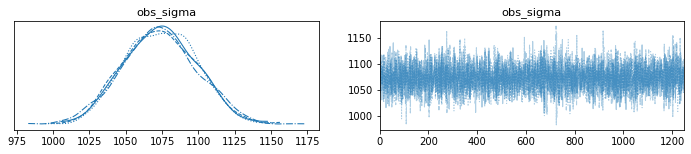

In [18]:
params = stan_mcmc.get_posterior_samples(permute=False, relabel=True) #достаём информацию о параметрах

az.plot_trace(params, var_names='obs_sigma')

Цепи все-таки сошлись, но с графиком предсказаний явно что-то не то. Давайте на него посмотрим.

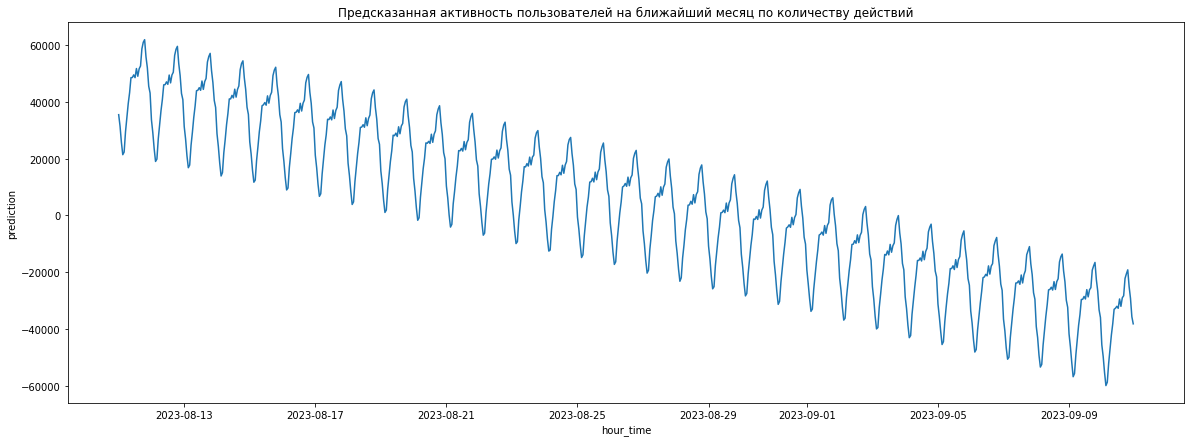

In [20]:
# предсказываем данные
predicted_stan_mcmc = stan_mcmc.predict(future_df)

# строим график
fig = plt.figure(figsize=(20,7))
sns.lineplot(predicted_stan_mcmc, x='hour_time', y='prediction').set(title='Предсказанная активность пользователей на ближайший месяц по количеству действий');

**Вывод:**  
Модель с алгоритмом stan-map показала хотя бы более-менее адекватный результат, именно поэтому попробуем использовать ее для оценки активности.

## **4.** Предсказываем активность пользователей на ближайший месяц

In [55]:
predicted_stan_map = stan_map.predict(future_df)
predicted_stan_map

,hour_time,prediction_5,prediction,prediction_95
0,2023-08-11 00:00:00,27124.190096,31269.173976,34720.706187
1,2023-08-11 01:00:00,22065.908982,26058.494797,29859.826001
2,2023-08-11 02:00:00,15706.222579,19818.529280,23731.193300
3,2023-08-11 03:00:00,9965.091251,14030.863998,17958.189426
4,2023-08-11 04:00:00,8973.138764,13004.791594,16958.658581
...,...,...,...,...
739,2023-09-10 19:00:00,30729.455713,60548.566537,89379.906948
740,2023-09-10 20:00:00,26524.197093,56325.735903,85479.435108
741,2023-09-10 21:00:00,27407.681972,56127.192575,83664.606973
742,2023-09-10 22:00:00,23875.780416,53474.074384,81707.026529


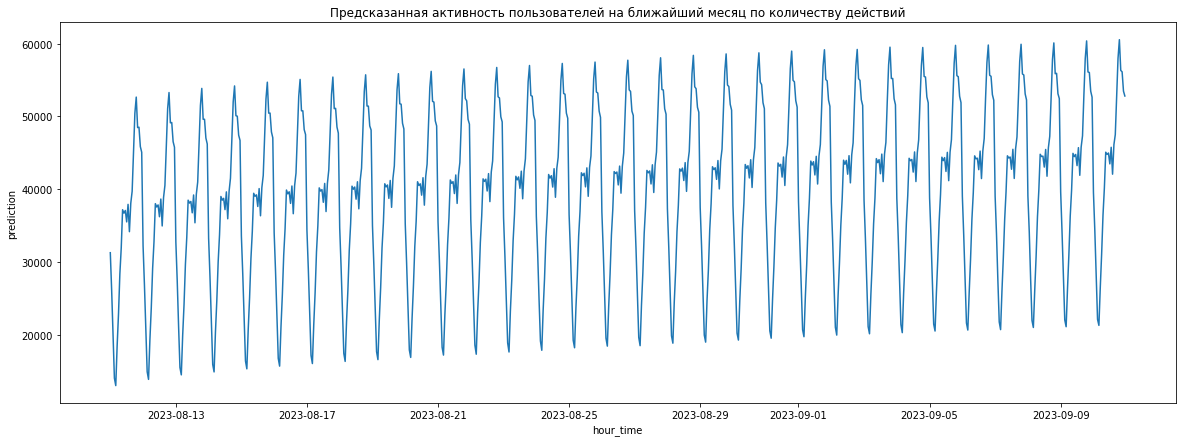

In [57]:
# строим график
fig = plt.figure(figsize=(20,7))
sns.lineplot(predicted_stan_map, x='hour_time', y='prediction').set(title='Предсказанная активность пользователей на ближайший месяц по количеству действий');

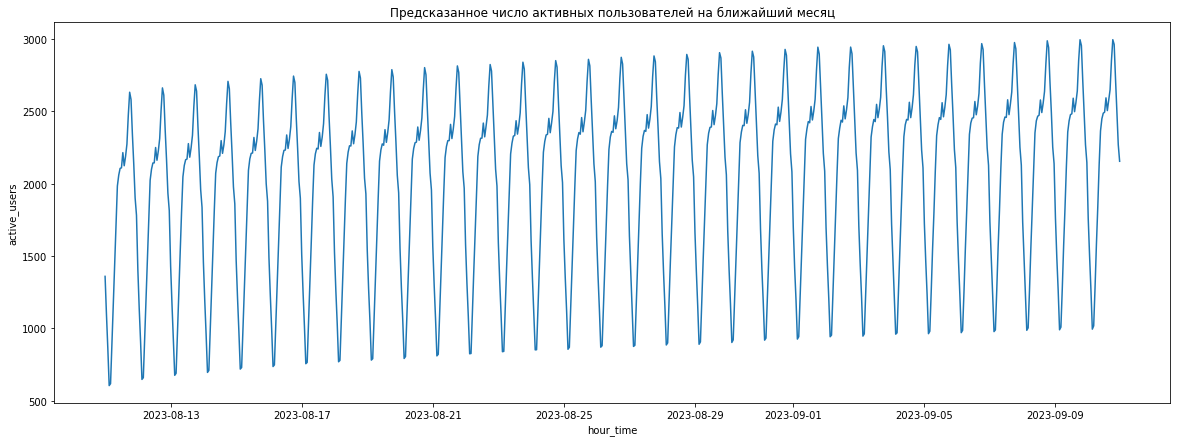

In [59]:
# строим график
fig = plt.figure(figsize=(20,7))
sns.lineplot(future_df, x='hour_time', y='active_users').set(title='Предсказанное число активных пользователей на ближайший месяц');

## **Вывод**:  
По результатам, представленным выше, ожидается, что в пике активность в ближайший месяц будет составлять около 60 тысяч действий и около 3 тысяч активных пользователей. Правда вот у нас такая активность и такое количество пользователей уже есть на текущий момент времени...
Прогнозирование с объемом данных за 2 месяца на месяц вперед обречено на провал. Любая модель дает неадекватно огромные доверительные интервалы уже через 7-10 дней. Попытки изменения данных с помощью z-стандартизации и логарифмирования также не меняли результат.

К сожалению, для адекватного проведения данного исследования необходимо намного большая мощность удаленного сервера и сильно больший временной ресурс. Без этого невозможно провести нормальную оптимизацию с адеватным числом итераций, бэктестинг и так далее. Тоже касается и использования предикторов. Однако сам механизм проведения предиктивной аналитики для временных рядов представлен. 